In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):  
    return glob.glob(path)    # Finds all the pathnames matching a specified pattern
print(findFiles('/content/data/names/*.txt'))

['/content/data/names/Polish.txt', '/content/data/names/German.txt', '/content/data/names/Czech.txt', '/content/data/names/Scottish.txt', '/content/data/names/Japanese.txt', '/content/data/names/Italian.txt', '/content/data/names/Chinese.txt', '/content/data/names/Russian.txt', '/content/data/names/Portuguese.txt', '/content/data/names/Irish.txt', '/content/data/names/Dutch.txt', '/content/data/names/Vietnamese.txt', '/content/data/names/Arabic.txt', '/content/data/names/Korean.txt', '/content/data/names/English.txt', '/content/data/names/French.txt', '/content/data/names/Spanish.txt', '/content/data/names/Greek.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + '.,;'
n_letters = len(all_letters)

# Converting Unicode to ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

category_lines = {}   # Language -> lines in text file
all_categories = []   # List of languages

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('/content/data/names/*.txt'):
    category = os.path. splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Greek'][:5])

['Adamidis', 'Adamou', 'Agelakos', 'Akrivopoulos', 'Alexandropoulos']


## CREATING THE NETWORK
<img src = 'https://i.imgur.com/jzVrf7f.png'/>

In [3]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)

        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

## Helper functions

In [4]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [5]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

## Training the RNN

In [6]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()
    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha = -learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [7]:
import time
import math

n_hidden = 128
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 1000

total_loss = 0   # resets every plot_every iters
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = s // 60
    return '%dm %ds' % (m, s - m*60)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 16s (5000 5%) 3.2551
0m 28s (10000 10%) 2.1973
0m 39s (15000 15%) 1.9816
0m 51s (20000 20%) 2.7656
1m 3s (25000 25%) 3.0441
1m 14s (30000 30%) 1.6563
1m 25s (35000 35%) 2.8501
1m 37s (40000 40%) 2.0563
1m 48s (45000 45%) 2.8055
1m 59s (50000 50%) 2.6973
2m 10s (55000 55%) 1.7357
2m 21s (60000 60%) 3.0591
2m 32s (65000 65%) 1.6766
2m 43s (70000 70%) 2.2164
2m 54s (75000 75%) 2.0068
3m 6s (80000 80%) 1.5533
3m 17s (85000 85%) 2.3357
3m 28s (90000 90%) 2.7711
3m 39s (95000 95%) 2.0465
3m 50s (100000 100%) 1.3913


## Plotting the losses

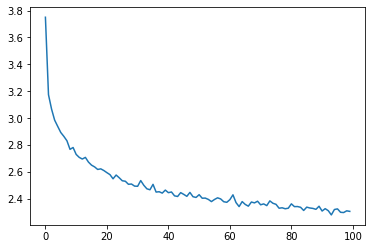

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

## Sampling the RNN

In [9]:
max_length = 20

def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')
samples('German', 'GER')
samples('Spanish', 'SPA')
samples('Chinese', 'CHI')

Roshak
Uanis
Shakinov
Ganter
Ering
Rong
Santa
Pera
Aranar
Cha
Han
Iin
